# Deep Hedging AI with Ray
### Multi-processing wih Ray.io


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14" ray
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
my_path = None
if i!=-1:
    my_path = p[:i]
    import sys
    sys.path.append(my_path)
    print("SageMaker: added python path %s" % my_path)
else:
    print(sys.path)

SageMaker: added python path /home/ec2-user/SageMaker


Autosaving every 60 seconds
Deep Hedging AI says hello ... Tensorflow version 2.11.0 running on 1 CPUs and 0 GPUs


2023-03-25 15:32:54.339279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Importing Ray ...


2023-03-25 15:32:57,666	INFO worker.py:1553 -- Started a local Ray instance.
2023-03-25 15:32:57,859	INFO packaging.py:503 -- Creating a file package for local directory '/home/ec2-user/SageMaker/deephedging'.
2023-03-25 15:32:58,036	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_7bd5da7bd558e933.zip' (43.70MiB) to Ray cluster...
2023-03-25 15:32:58,784	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_7bd5da7bd558e933.zip'.


Ray imported


## Plotting payoff American Digital @ 0.95

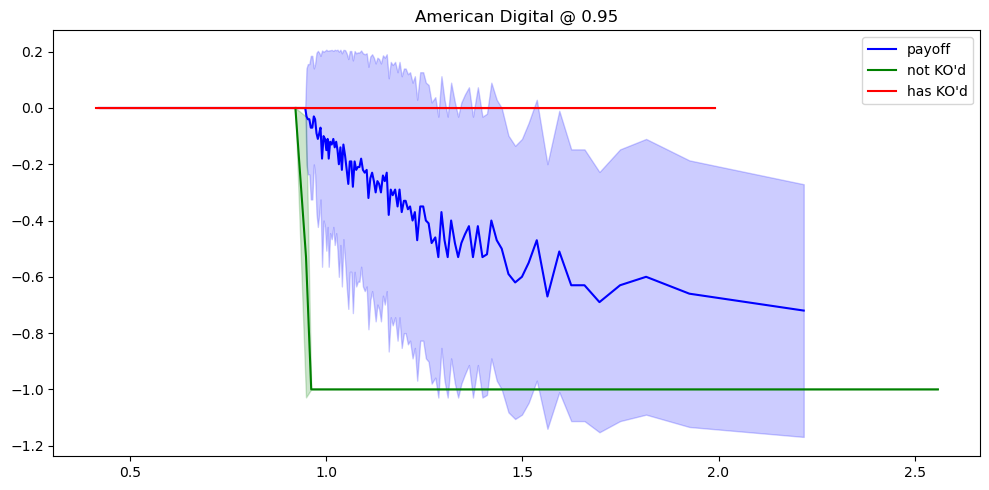

In [2]:
%matplotlib inline
%autosave 60
print("Deep Hedging AI says hello ... ", end='')

import importlib as imp
import deephedging.plot_training as _
imp.reload(_)
import deephedging.trainer as _
imp.reload(_)

from cdxbasics.config import Config
from cdxbasics.prettydict import PrettyOrderedDict as pdct
import deephedging as deephedging
from deephedging.trainer import train
from deephedging.plot_training import Plotter
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
from cdxbasics.dynaplot import figure, colors_tableau
import numpy as np
from IPython.display import display, Markdown

print("Importing Ray ...")
import ray as ray
import ray.util.queue as ray_queue#

runtime_env = {#"working_dir": my_path, 
               "pip": ["cvxpy", "tensorflow==2.10", "tensorflow_probability==0.14", "cdxbasics"],
               "py_modules": [deephedging],
               "excludes": ["*.pack", "*.pck", "/lost+found/*" ]
              }
ray.shutdown()
ray.init(runtime_env=runtime_env)

print("Ray imported")


config = Config()
# world
config.world.steps = 20*5
config.world.dt    = 1./50.

nBins = 200

barrier = 0.95
def payoff_def( spots ):
    notko      = np.cumprod( np.where( spots > barrier, 1., 0. ), axis=1 )
    terminal   = 1.
    return dict( payoff=-terminal*notko[:,-1],
                 features=notko[:,:-1] )
payoff_def.name = "American Digital @ %g" % (barrier)

config.world.samples = 20000
config.world.drift = 0.
config.world.cost_s = 0.
config.world.black_scholes = True
config.world.payoff = payoff_def
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 50
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence.states.classic   = 1
config.gym.agent.recurrence.states.aggregate = 1
config.gym.agent.recurrence.states.past_repr = 1
config.gym.agent.recurrence.states.event     = 1
config.gym.agent.features = ['price', 'delta', 'time_left', 'payoff_features']
#
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.0001
config.trainer.train.optimizer.clipvalue = 0.9
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 500
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75
config_ref = config.copy()  # create unused copy

# create world
world      = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//2)

# plot
# ----

display(Markdown("## Plotting payoff " + payoff_def.name))
from deephedging.base import npCast, mean_bins
from cdxbasics.dynaplot import figure, colors_base
import numpy as np

payoff = world.data.market.payoff
spots  = world.details.spot_all
notko  = world.data.features.per_step.payoff_features
ref    = spots[:,-1]
ixs    = np.argsort(ref)
nko_s  = notko[ixs,-1]
ref_s  = ref[ixs]
pyo_s  = payoff[ixs]
colors = colors_base()

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("%s" % payoff_def.name)

xm   = mean_bins( ref_s, bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( pyo_s, bins=nBins, weights=world.sample_weights, return_std = True )
col  = next(colors)
ax.plot( xm, m, color=col, label="payoff")
ax.fill_between( xm, m-s,m+s, color=col,alpha=0.2)

xm   = mean_bins( ref_s[nko_s > 0.], bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( pyo_s[nko_s > 0.], bins=nBins, weights=world.sample_weights, return_std = True )
col  = next(colors)
ax.plot( xm, m, color=col, label="not KO'd")
ax.fill_between( xm, m-s,m+s, color=col,alpha=0.2)

xm   = mean_bins( ref_s[nko_s < 1.], bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( pyo_s[nko_s < 1.], bins=nBins, weights=world.sample_weights, return_std = True )
col  = next(colors)
ax.plot( xm, m, color=col, label="has KO'd")
ax.fill_between( xm, m-s,m+s, color=col,alpha=0.2)

ax.legend()
fig.close()



Launching 5 training loops


(train_loop pid=17791) 2023-03-25 15:33:45.520010: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(train_loop pid=17790) 2023-03-25 15:33:45.637567: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(train_loop pid=17787) 2023-03-25 15:33:45.723694: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(train_loop pid=17788) 2023-03-25 15:33:45.837884: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(train_loop pid=17789) 2023-03-25 15:33:46.070227: E tensorflow/stream_executor/cuda/cuda_blas.cc:29

(train_loop pid=17788) Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


(train_loop pid=17788) 2023-03-25 15:33:49.420401: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(train_loop pid=17790) Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs
(train_loop pid=17791) Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


(train_loop pid=17790) 2023-03-25 15:33:49.869954: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(train_loop pid=17791) 2023-03-25 15:33:49.948032: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(train_loop pid=17787) Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs
(train_loop pid=17789) Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


(train_loop pid=17787) 2023-03-25 15:33:50.078494: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(train_loop pid=17789) 2023-03-25 15:33:50.176348: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(train_loop pid=17788) Ray train_loop digital started. Adding path /home/ec2-user/SageMaker
(train_loop pid=17791) Ray train_loop standard started. Adding path /home/ec2-user/SageMaker
(train_loop pid=17790) Ray train_loop none started. Adding path /home/ec2-user/SageMaker
(train_loop pid=17787) Ray train_loop mix_100_relu started. Adding path /home/ec2-user/SageMaker
(train_loop pid=17789) Ray train_loop mix_100_softplus started. Adding path /home/ec2-user/SageMaker
(train_loop pid=17787) Initializing training at 2023-03-25 15:34:13: gym with 42.22K trainable weights compiled. Took 19s
(train_loop pid=17787) Agent is using 42214 weights: 42209 for the main agent per step, 1 for initial delta, 4 for initial states.
(train_loop pid=17787)  Features available per time step:     action, cost, delta, ivol, lbnd_a, payoff_features, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
(train_loop pid=17787)  Features used per time step:          delta, payoff_features, pri

(_QueueActor pid=17786) 2023-03-25 15:38:31.143413: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


                                                                                                                                                                                                         
(_QueueActor pid=17786) Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


(_QueueActor pid=17786) 2023-03-25 15:38:35.808485: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


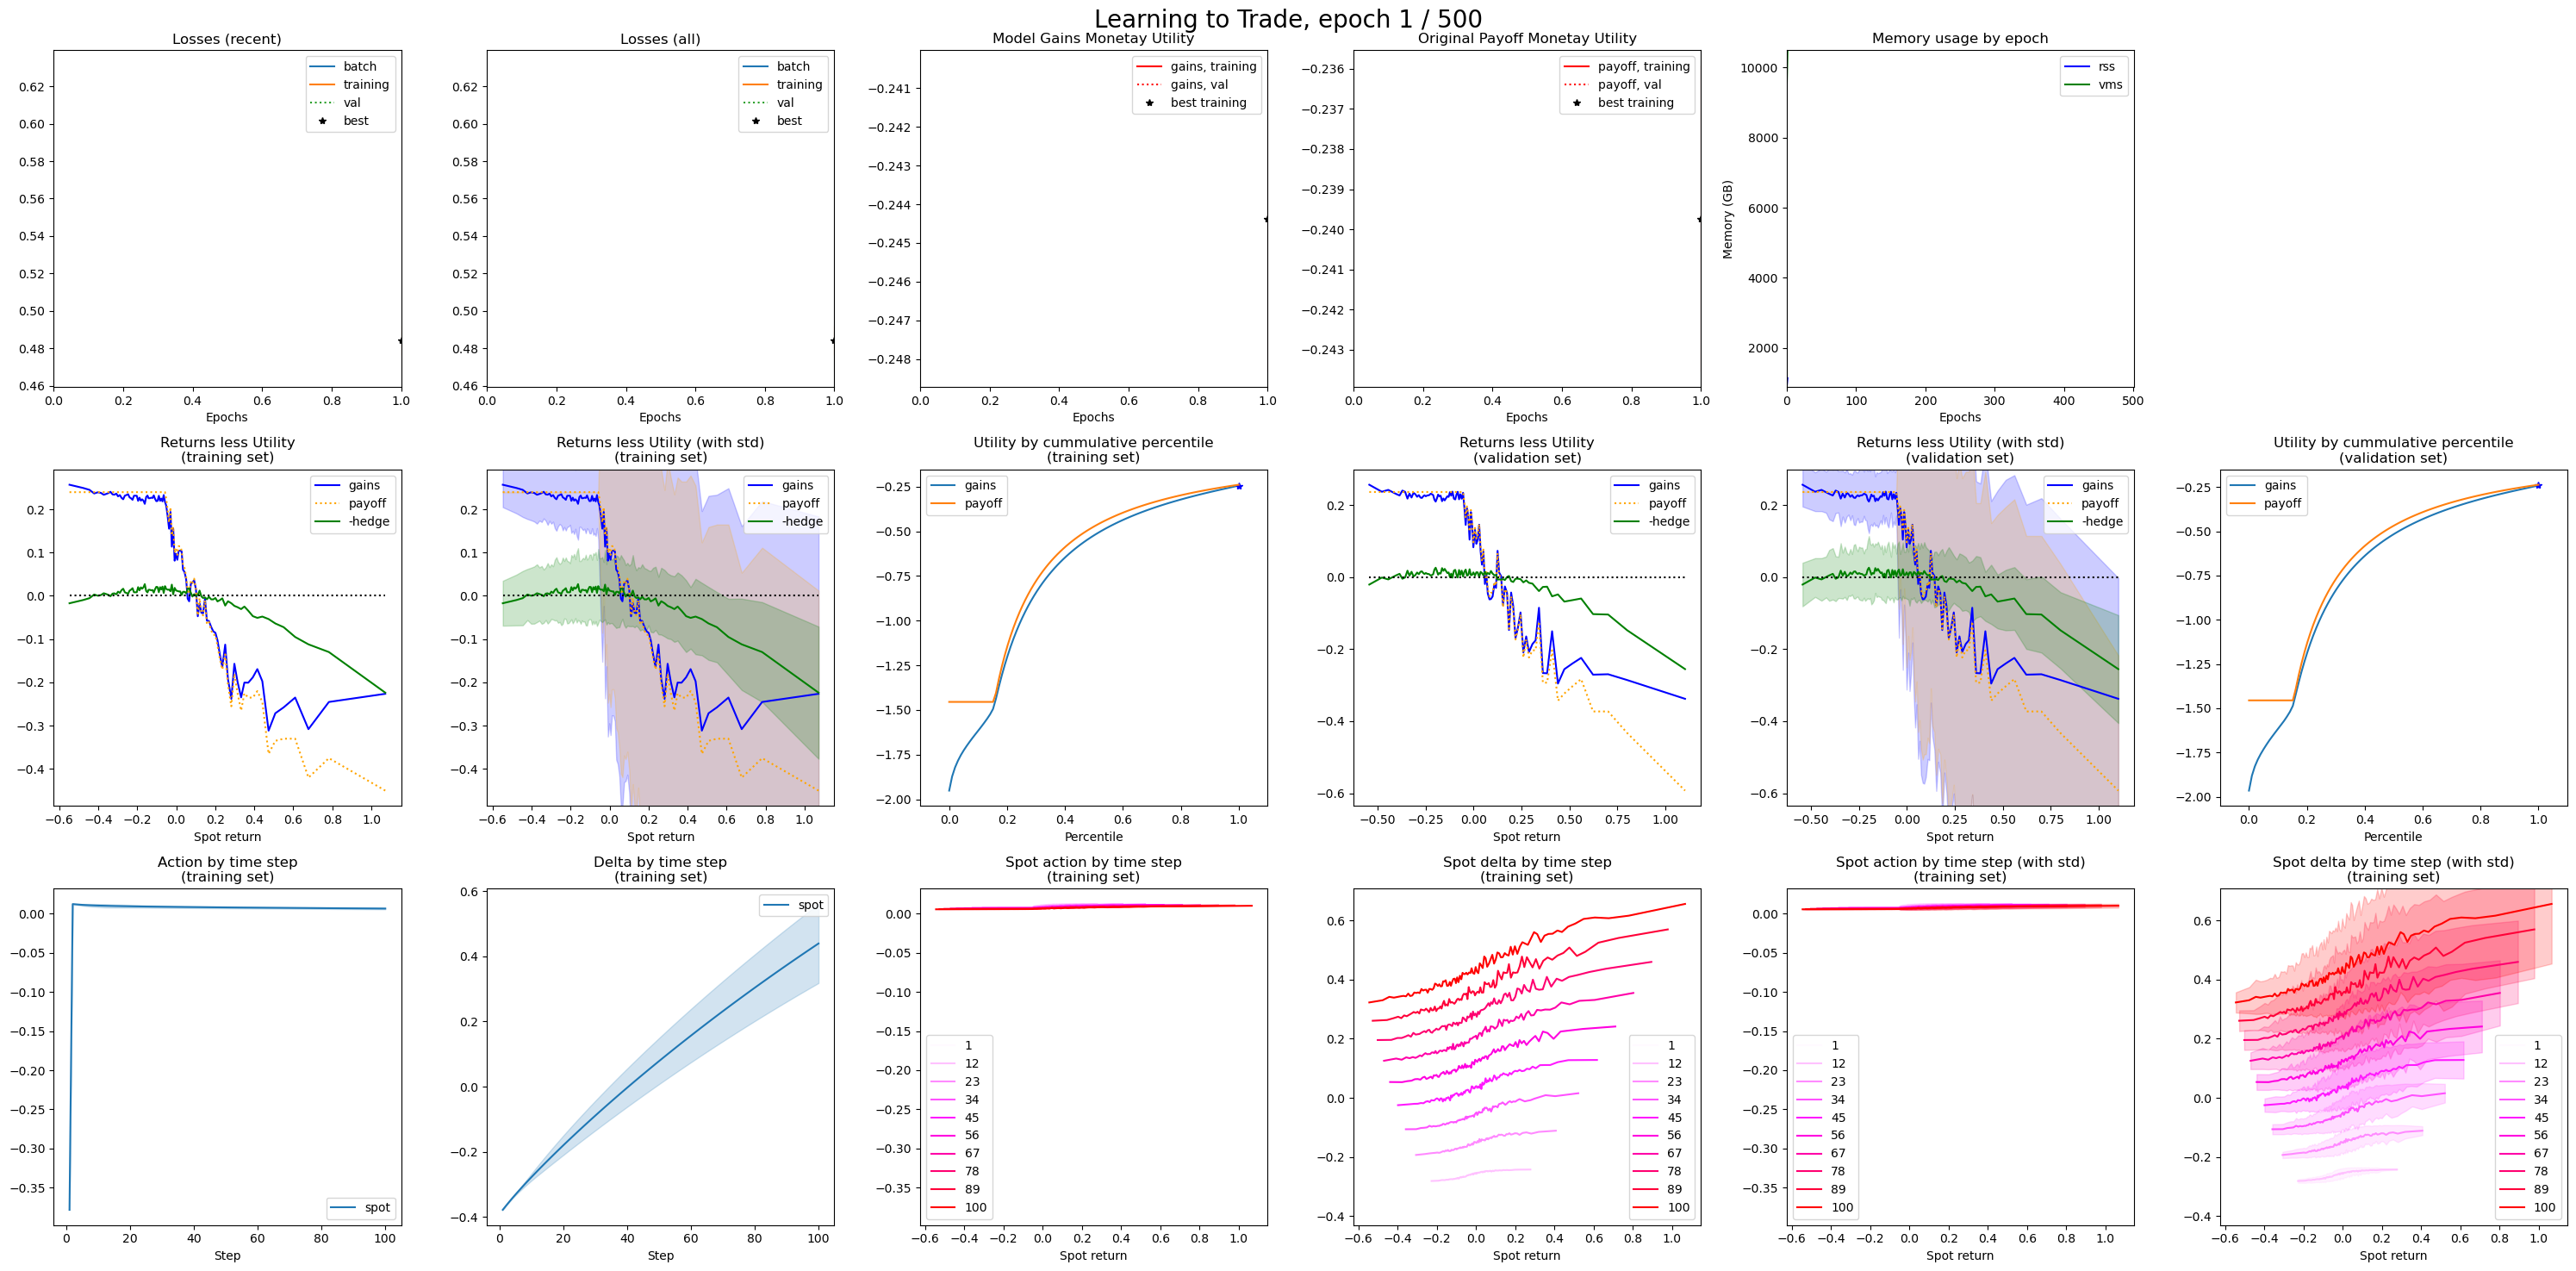

                                                                                                                                                                                                         
Training 1/500 epochs; 10.5K weights; 20000 samples; 10000 validation samples batch size 32 | initial loss 8.22806 (0.170463), training 0.484098 (0.00771756), best 0.484098 (0.170463), batch 0.63114, val 0.478458 (0.0108614); best epoch 1, last cached 1 | memory used: rss 1140.84M, vms 10478.4M | time elapsed 3:32; time per epoch 3:32; estimated time remaining 29:24:50 | current time: 2023-03-25 15:38:48, estimated end time: 2023-03-26 21:03:39                        


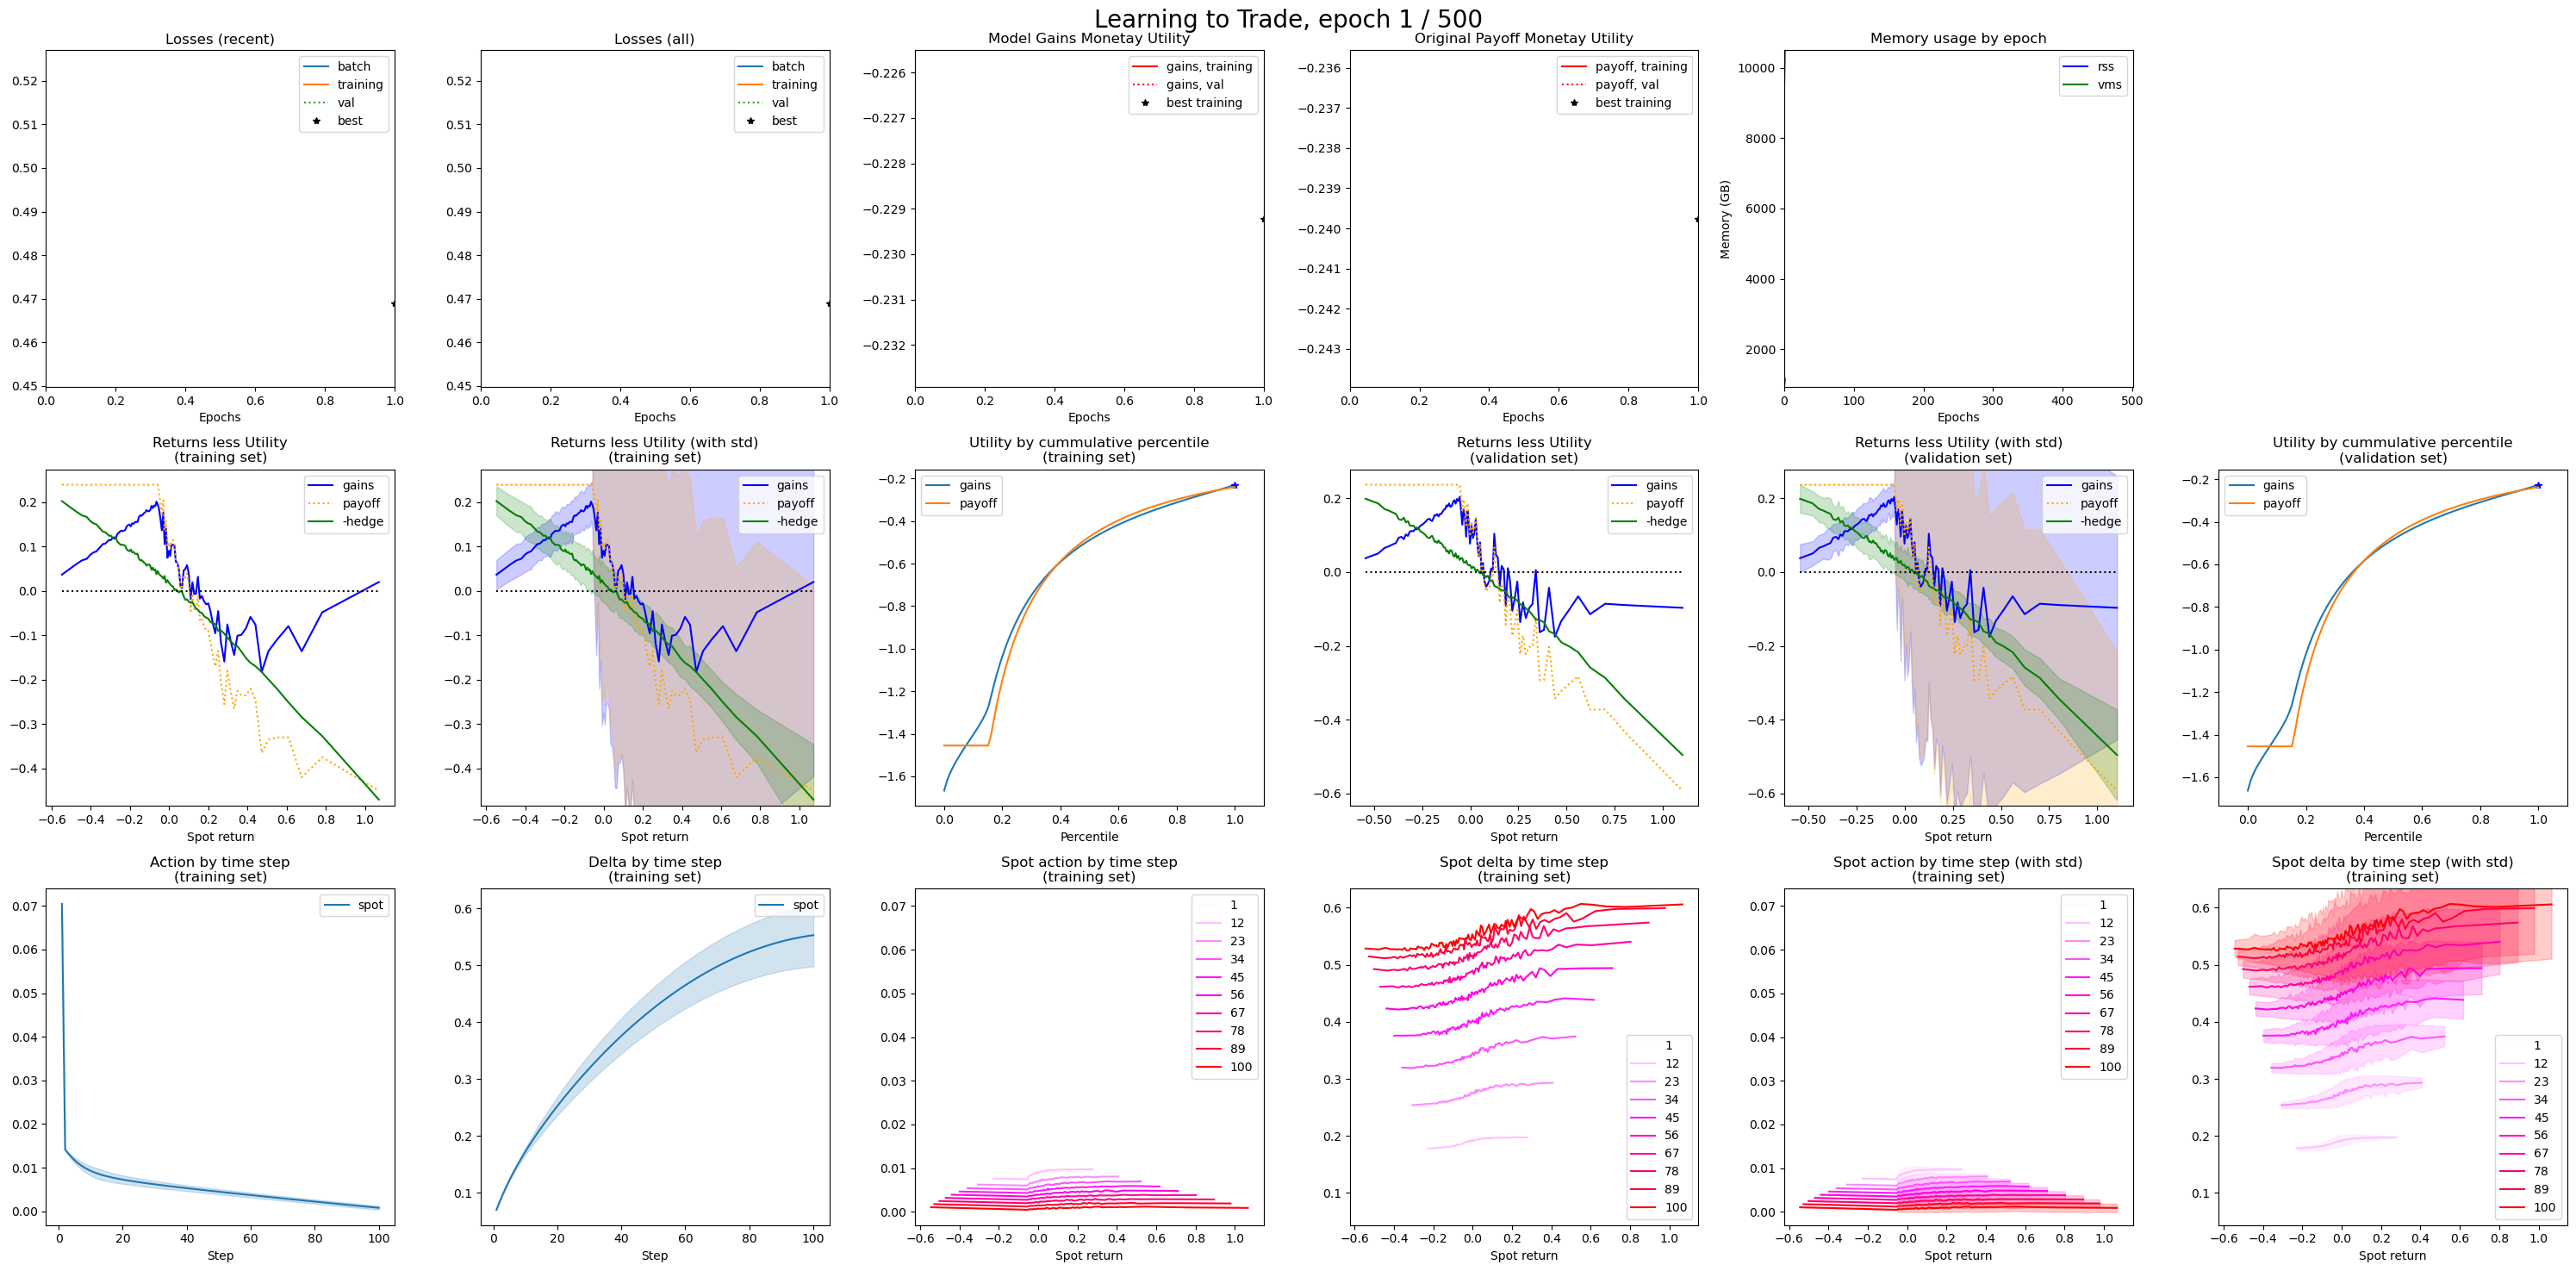

Training 1/500 epochs; 11.27K weights; 20000 samples; 10000 validation samples batch size 32 | initial loss 3.5558 (0.0705984), training 0.468968 (0.00709734), best 0.468968 (0.0705984), batch 0.523476, val 0.46331 (0.00997068); best epoch 1, last cached 1 | memory used: rss 1154.07M, vms 10485.8M | time elapsed 3:45; time per epoch 3:45; estimated time remaining 31:16:57 | current time: 2023-03-25 15:38:57, estimated end time: 2023-03-26 22:55:54                        


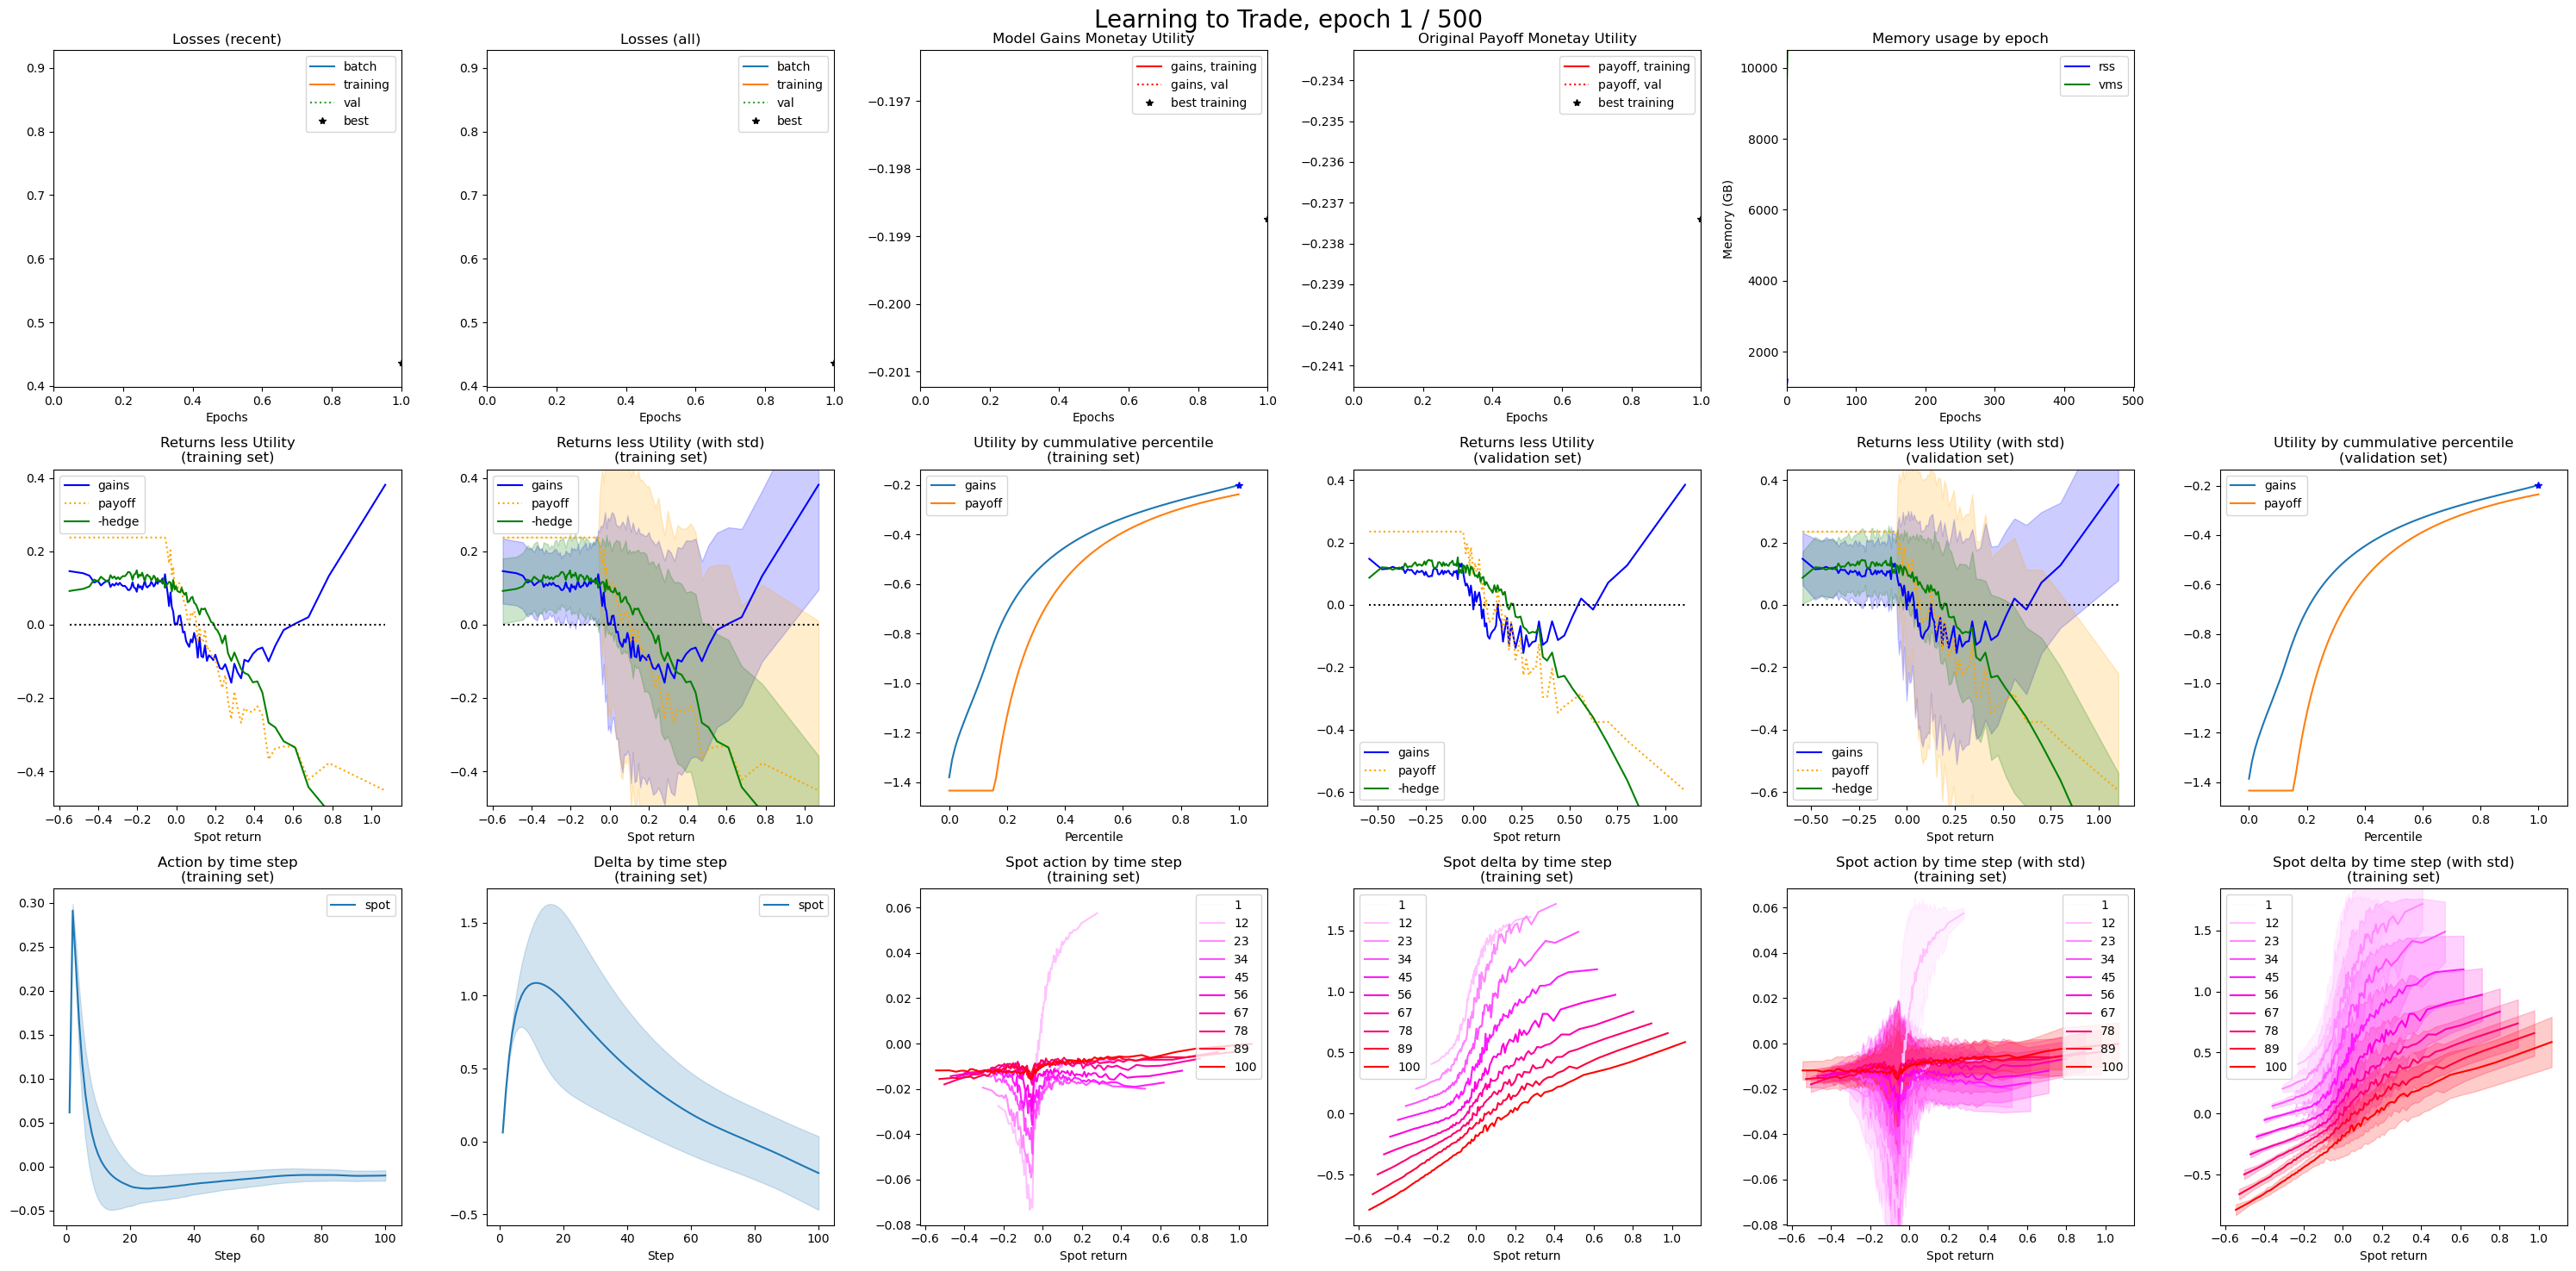

Training 1/500 epochs; 42.22K weights; 20000 samples; 10000 validation samples batch size 32 | initial loss 14.8747 (0.312944), training 0.436122 (0.00576706), best 0.436122 (0.312944), batch 0.90375, val 0.430966 (0.00808835); best epoch 1, last cached 1 | memory used: rss 1216.48M, vms 10488.8M | time elapsed 4:03; time per epoch 4:03; estimated time remaining 33:49:09 | current time: 2023-03-25 15:39:06, estimated end time: 2023-03-27 01:28:16                        


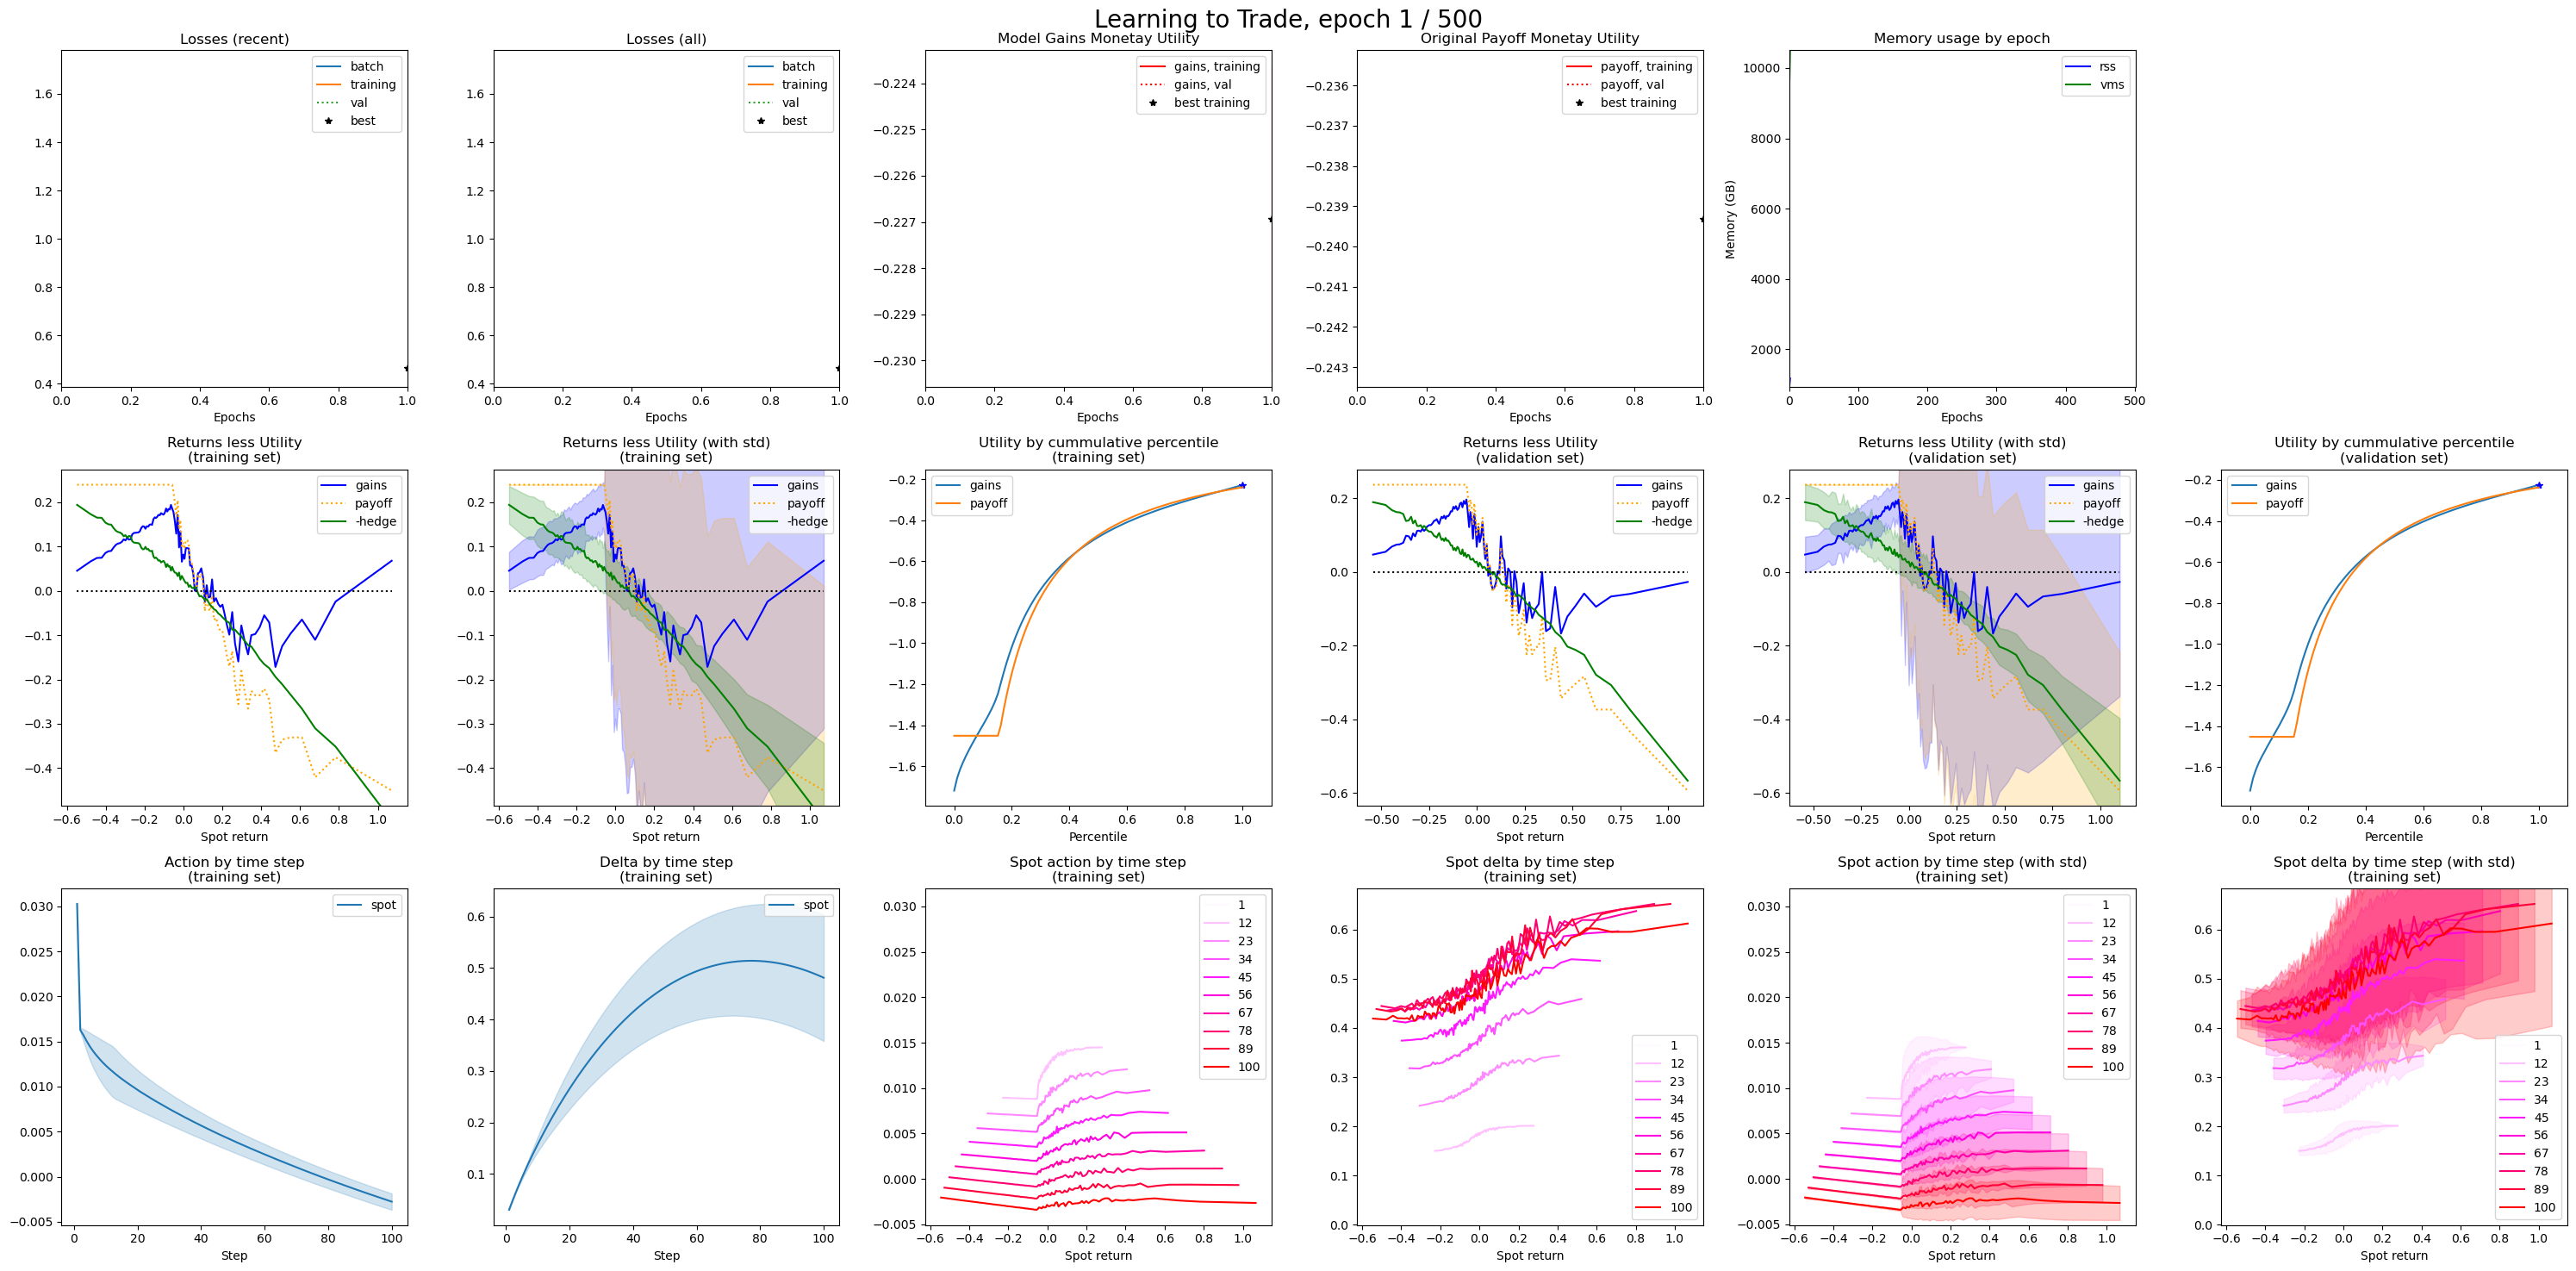

                                                                                                                                                                                                         l 0.460382 (0.00984655); best epoch 1, last cached 1 | memory used: rss 1163.78M, vms 10496.5M | time elapsed 4:10; time per epoch 4:10; estimated time remaining 34:44:28 | current time: 2023-03-25 15:39:21, estimated end time: 2023-03-27 02:23:50                        (train_loop pid=17789) 



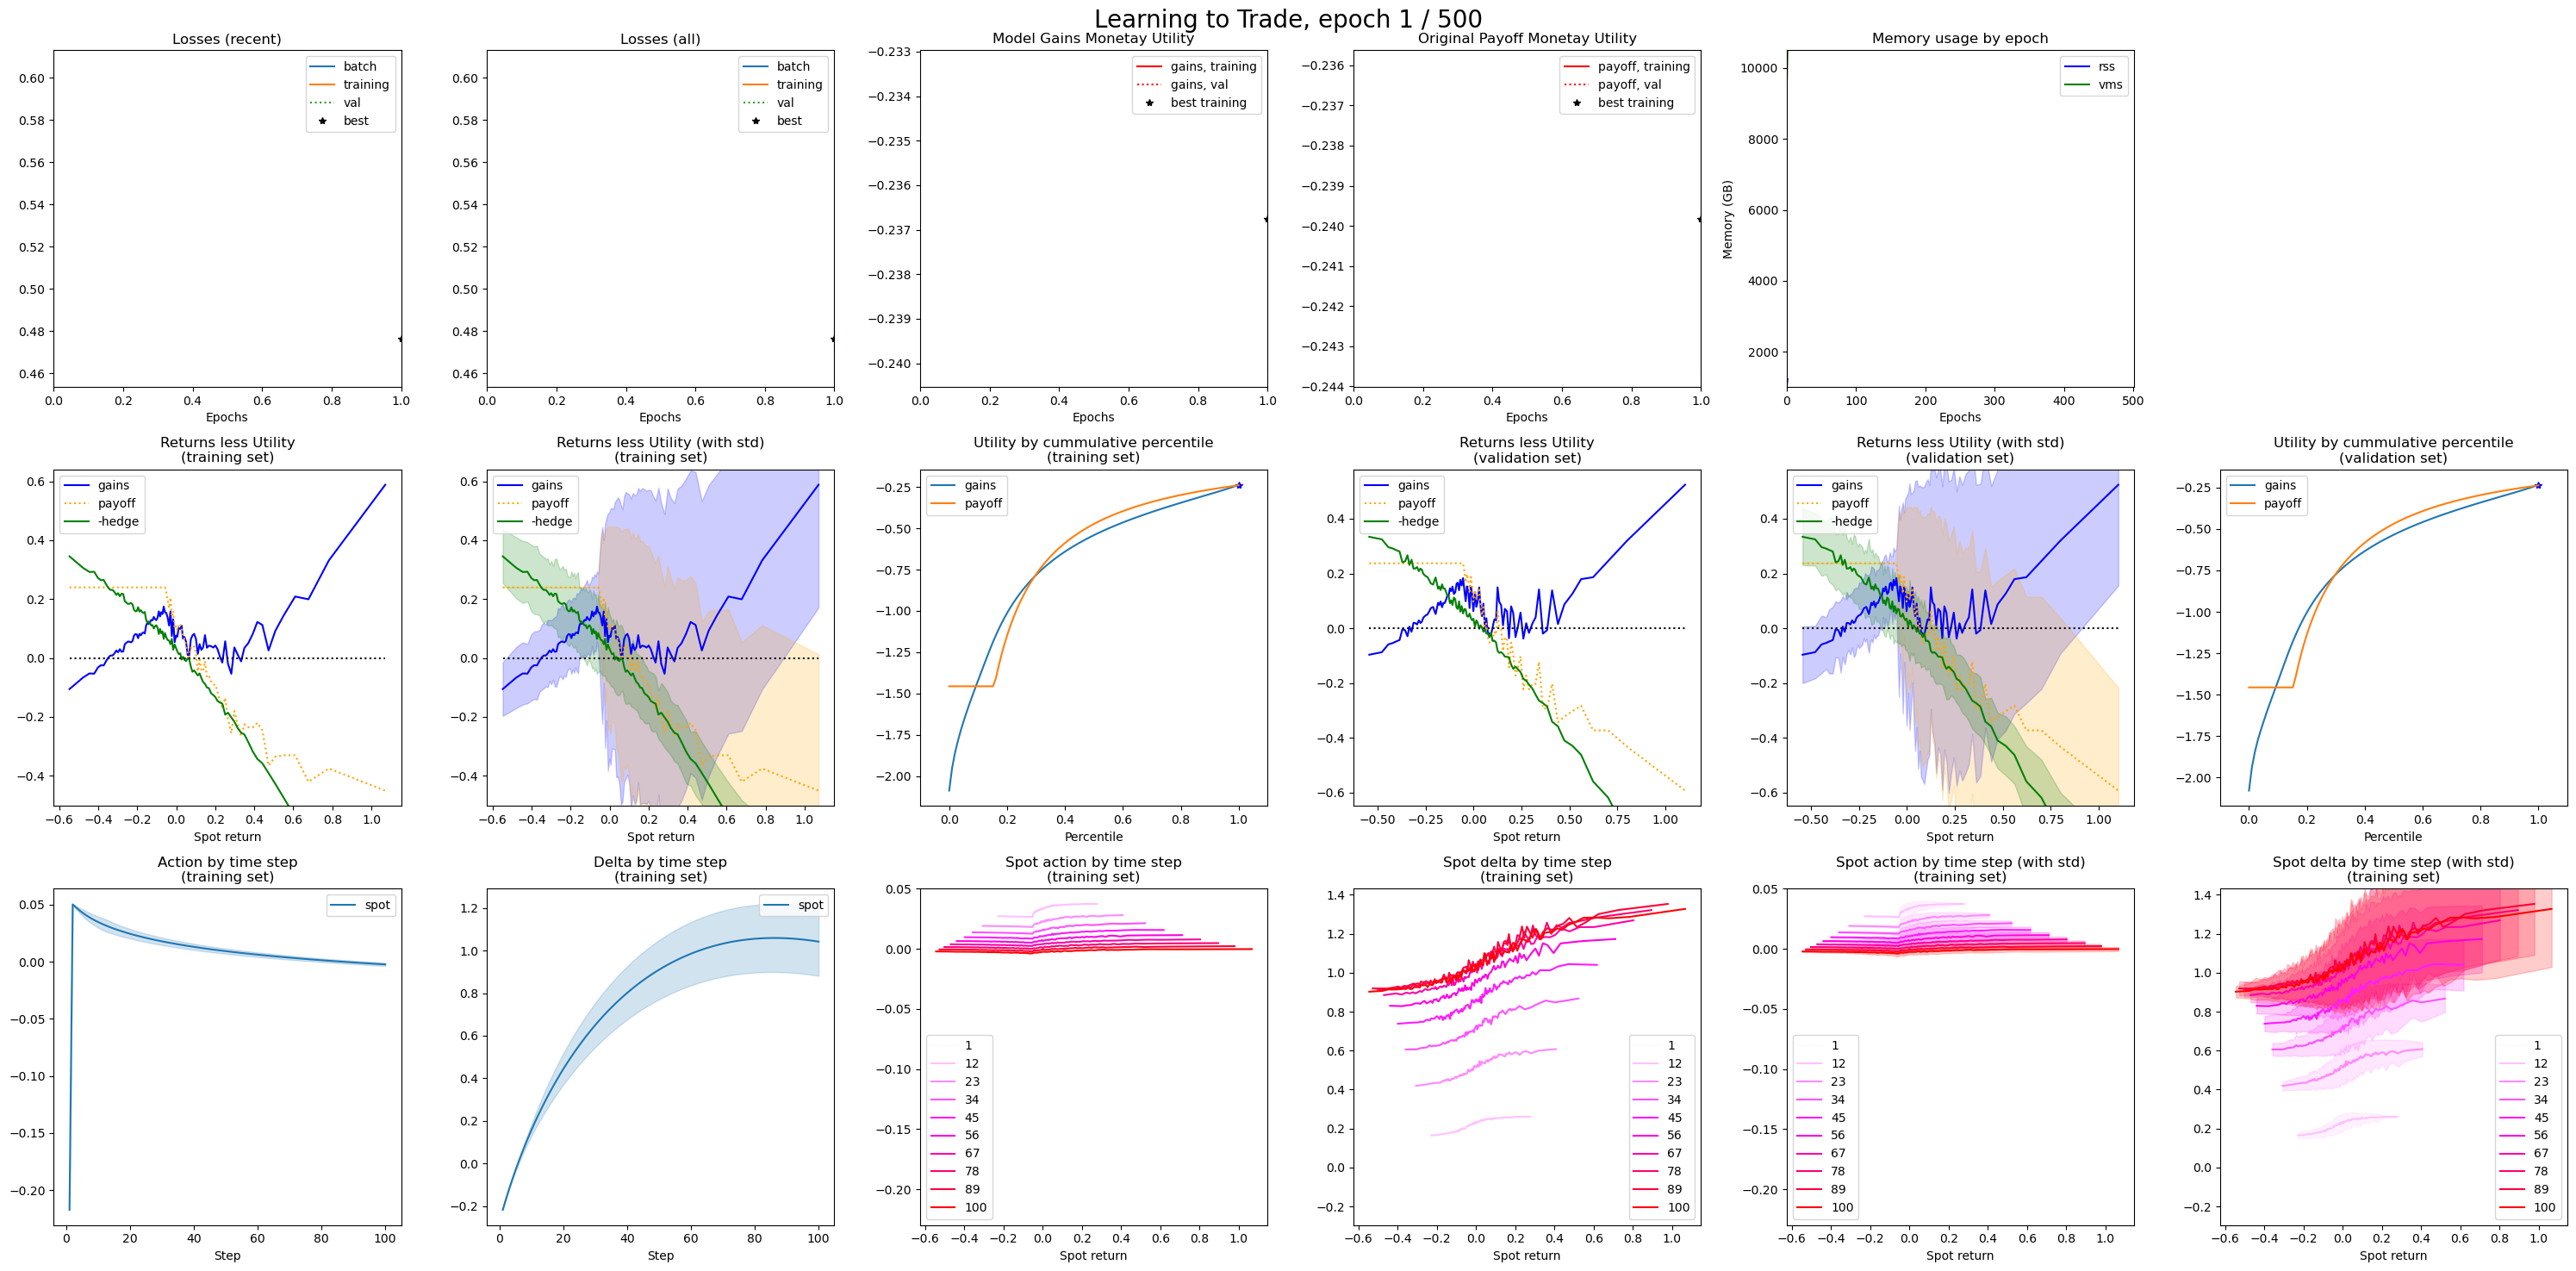

Training 2/500 epochs; 10.5K weights; 20000 samples; 10000 validation samples batch size 32 | initial loss 8.22806 (0.170463), training 0.47329 (0.00741663), best 0.47329 (0.170463), batch 0.484944, val 0.467343 (0.0104303); best epoch 2, last cached 1 | memory used: rss 1174.45M, vms 10628.7M | time elapsed 7:41; time per epoch 3:50; estimated time remaining 31:55:23 | current time: 2023-03-25 15:42:35, estimated end time: 2023-03-26 23:37:58                            

In [ ]:
# Create test configs
# -------------------

queue = ray_queue.Queue()
configs = pdct()
world_ref = ray.put(world)
val_world_ref = ray.put(val_world)

# not recurrent
config = config_ref.copy()
config.gym.agent.recurrence.states.classic   = 0
config.gym.agent.recurrence.states.aggregate = 0
config.gym.agent.recurrence.states.past_repr = 0
config.gym.agent.recurrence.states.event     = 0
config.world.mark_done()
configs.none = config

# digital states
config = config_ref.copy()
config.gym.agent.recurrence.states.classic   = 0
config.gym.agent.recurrence.states.aggregate = 0
config.gym.agent.recurrence.states.past_repr = 5
config.gym.agent.recurrence.states.event     = 5
config.world.mark_done()
configs.digital = config

# standard recurrence
config = config_ref.copy()
config.gym.agent.recurrence.states.classic   = 0
config.gym.agent.recurrence.states.aggregate = 5
config.gym.agent.recurrence.states.past_repr = 0
config.gym.agent.recurrence.states.event     = 0
config.world.mark_done()
configs.standard = config

# standard recurrence + big
config = config_ref.copy()
config.gym.agent.recurrence.states.classic   = 0
config.gym.agent.recurrence.states.aggregate = 2
config.gym.agent.recurrence.states.past_repr = 2
config.gym.agent.recurrence.states.event     = 0
config.gym.user_version = 1
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 100
config.gym.agent.network.activation = "relu"
config.world.mark_done()
configs.mix_100_relu = config

# standard recurrence + big
config = config_ref.copy()
config.gym.agent.recurrence.states.classic   = 0
config.gym.agent.recurrence.states.aggregate = 2
config.gym.agent.recurrence.states.past_repr = 2
config.gym.agent.recurrence.states.event     = 0
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 100
config.gym.agent.network.activation = "softplus"
config.world.mark_done()
configs.mix_100_softplus = config

# Launch Ray
# ----------

use_ray = True

@ray.remote
def train_loop( id, queue, world, val_world, config ):    
    try:
        print("Ray train_loop %s started. Adding path %s" % (id, my_path))
        import sys
        sys.path.append(my_path)
        from deephedging.gym import VanillaDeepHedgingGym
        from deephedging.trainer import train
        from deephedging.base import npCast

        class RemotePlotter(object):
            def __init__(self, id ):
                self.id = id
            def __call__(self, *, last_cached_epoch, progress_data, training_info ):
                queue.put( pdct(id=id, done=False, last_cached_epoch=last_cached_epoch, progress_data=progress_data, training_info=training_info) )
            def close(self):
                pass

        remote_plotter = RemotePlotter(id)
        gym = VanillaDeepHedgingGym( config.gym )
        train( gym=gym, world=world, val_world=val_world, remote_plotter=remote_plotter, config=config.trainer )
        results = npCast( gym(world.tf_data) )
        queue.put( pdct(id=id, done=True, results=results )  )
        print("Ray training_remote %s finished" % id)
    except KeyboardInterrupt:
        print("Ray training_remote %s interrupted" % id)
    except Exception as e:
        print("Ray training_remote %s interrupted by exception %s" % (id, str(e)))
        results = npCast( gym(world.tf_data) )
        queue.put( pdct(id=id, done=True, results=results )  )

if use_ray:
    print("Launching %ld training loops" % len(configs))
    futures  = [ train_loop.remote(id=n, queue=queue, world=world_ref, val_world=val_world_ref, config=configs[n] ) for n in configs ]
    plotters = { n : Plotter( world=world, val_world=val_world, plot_graphs=True, config=configs[n].train.visual ) for n in configs }
    results  = pdct()

    def update_loop():
        while True:
            data = queue.get()
            id   = data.id
            if not data.done:
                plotters[id]( last_cached_epoch=data.last_cached_epoch, progress_data=data.progress_data, training_info=data.training_info )
                continue

            assert not id in results
            results[id] = data.results
            plotters[id].close()
            del plotters[id]

            if len(results) == len(configs):
                return

    try:
        update_loop()
    except KeyboardInterrupt:
        print("Ctrl+C")

    print("Cleaning up...")
    for f in futures:
        ray.cancel( f )

    for n in plotters:
        plotters[n].close()
        del plotters[n]
else:
    results = pdct()
    for k in configs:
        display(Markdown("## " + k))
        config = configs[k]
        gym = VanillaDeepHedgingGym( config.gym )
        train( gym=gym, world=world, val_world=val_world, config=config.trainer )
        results[k] = npCast( gym(world.tf_data) )

print("/Done")

In [ ]:
# train
# ----

if False:
    results = pdct()
    for k in configs:
        config = configs[k]
        display(Markdown("## Hedging a %s in recurrent '%s' mode" % (payoff_def.name, k)))
        gym = VanillaDeepHedgingGym( config.gym )
        train( gym=gym, world=world, val_world=val_world, config=config.trainer )
        results[k] = npCast( gym(world.tf_data) )
    


In [ ]:
from deephedging.base import npCast, mean_bins
from deephedging.fd import bs_fd
from deephedging.objectives import MonetaryUtility
from cdxbasics.dynaplot import figure, colors_base
from scipy.stats import norm
import math as math
import numpy as np

spots      = world.details.spot_all
hedges     = world.data.market.hedges[:,:,0]
time_left  = world.data.features.per_step.time_left[0,:]
nSteps     = world.nSteps
nSamples   = world.nSamples
nBins      = 200
nBinSteps  = 7
fdstd      = 5.
fdgrid     = 701
times      = world.timeline
ixs        = np.linspace(0,nSteps,nBinSteps,endpoint=True,dtype=np.int32)
vol        = config.world.get_raw("rvol", 0.2)

# collect actions
actions = { k: results[k]['actions'][:,:,0] for k in results }
deltas  = { k: np.cumsum( actions[k], axis=1) for k in results }
pnls    = { k: np.zeros((nSamples,)) for k in results }
act_pnls = { k: results[k]['pnl'] for k in results }
pnls['blackscholes'] = np.zeros((nSamples,))
prev_deltas_t  = { k: 0. for k in pnls }

keys_sorted = ['blackscholes'] + list( results.keys() )

# FD pricer
# ---------
def fd_payoff( X, F, t ):
    F     = - 1. if F is None else F
    return np.where( X > barrier, F, 0. )
fd_spots = np.exp( np.linspace(-fdstd,+fdstd,1+2*(fdgrid//2),endpoint=True) * vol * math.sqrt(times[-1]) )
fd = bs_fd( spots=[fd_spots]*(nSteps+1), times=times, payoff=fd_payoff, vol=vol, cn_factor='implicit')
notko = world.data.features.per_step.payoff_features

# plot hedging
# ------------

display(Markdown("## %s Hedging" % payoff_def.name))
fig = figure()

for j in range(nSteps):
    ax_delta  = fig.add_subplot()

    # sort by spot at j, and compute BS refernece
    spot_t    = spots[:,j]
    hedges_t  = hedges[:,j]   # S(T)-S(t_j)
    res_t     = time_left[j]
    dt        = times[j+1] - times[j]
    
    deltas_t  = { k: deltas[k][:,j] for k in deltas }    
    bsdelta_t = fd[j].bump_delta( spot_t, 0.5 * vol * math.sqrt(dt) )
    deltas_t['blackscholes'] \
              = - bsdelta_t * notko[:,j]
    trades_t  = { k: deltas_t[k] - prev_deltas_t[k] for k in deltas_t }
    pnls      = { k: pnls[k] + trades_t[k] * hedges_t for k in pnls }
    prev_deltas_t = deltas_t

    # plot
    ixs       = np.argsort(spot_t)
    spot_t    = spot_t[ixs]
    deltas_t  = { k: deltas_t[k][ixs] for k in deltas_t }
    
    x_mean    = mean_bins( spot_t, bins=nBins, weights=world.sample_weights, return_std = False )
    colors    = colors_base()
    for k in keys_sorted:
        mean, std = mean_bins( deltas_t[k], bins=nBins, weights=world.sample_weights, return_std = True )
        color     = next(colors)
        ax_delta.plot( x_mean, mean, label=k, color=color)
        ax_delta.fill_between( x_mean, mean-std, mean+std, color=color, alpha=0.1 )

    ax_delta.set_title("Deltas time step %ld (%g)" % (j, times[j]))
    ax_delta.legend()
    
fig.render()
fig.close()

# terminal
# --------

display(Markdown("## Terminal %s Profiles" % payoff_def.name))

spots    = world.details.spot_all
payoff   = world.data.market.payoff
notko    = world.data.features.per_step.payoff_features[:,-1]
payoff   = payoff - np.mean( payoff )

spot_ret = spots[:,-1]
ixs      = np.argsort(spot_ret)
spot_ret = spot_ret[ixs]
pnls     = { k : pnls[k][ixs] for k in pnls }
payoff   = payoff[ixs]
notko    = notko[ixs]

# basic
spot_mean = mean_bins( spot_ret, bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff, bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("Terminal Payoff")
ax.set_xlabel("Spot")

colors = colors_base()
ax.plot( spot_mean, -payoff_mean, "--", label="-payoff", color="black")
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
_min = np.min(-payoff_mean-payoff_std)
_max = np.max(-payoff_mean+payoff_std)
for k in keys_sorted:
    color = next(colors)
    mean, std = mean_bins( pnls[k], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )
    _min = min(np.min(mean),_min)
    _max = max(np.max(mean),_max)

ax.legend()
dm = max(_max - _min, 0.001)
_max == dm*0.005
_min -= dm*0.005
ax.set_ylim(_min,_max)
fig.render()
fig.close()

# basic act
spot_mean = mean_bins( spot_ret, bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff, bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("TF Terminal Payoff")
ax.set_xlabel("Spot")

colors = colors_base()
ax.plot( spot_mean, -payoff_mean, "--", label="-payoff", color="black")
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
_min = np.min(-payoff_mean-payoff_std)
_max = np.max(-payoff_mean+payoff_std)
for k in sorted(act_pnls.keys()):
    color = next(colors)
    mean, std = mean_bins( act_pnls[k], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )
    _min = min(np.min(mean),_min)
    _max = max(np.max(mean),_max)

ax.legend()
dm = max(_max - _min, 0.001)
_max == dm*0.005
_min -= dm*0.005
ax.set_ylim(_min,_max)
fig.render()
fig.close()

# not KO'd
print(spot_ret.shape, notko.shape)
spot_mean = mean_bins( spot_ret[notko > 0.], bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff[notko > 0.], bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("Terminal Payoff\nNot KO'd")
ax.set_xlabel("Spot")

colors = colors_base()
ax.plot( spot_mean, -payoff_mean, "--", label="-payoff", color="black")
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
for k in keys_sorted:
    color = next(colors)
    mean, std = mean_bins( pnls[k][notko > 0.], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )

ax.legend()
ax.set_ylim(_min,_max)
fig.render()
fig.close()

# KO'd
spot_mean = mean_bins( spot_ret[notko < 1.], bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff[notko < 1.], bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("Terminal Payoff\nKO'd")
ax.set_xlabel("Spot")

colors = colors_base()
ax.plot( spot_mean, -payoff_mean, "--", label="-payoff", color="black")
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
for k in keys_sorted:
    color = next(colors)
    mean, std = mean_bins( pnls[k][notko < 1.], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )

ax.legend()
ax.set_ylim(_min,_max)
fig.render()
fig.close()



In [ ]:
from deephedging.objectives import oce_utility
from cdxbasics.dynaplot import figure, colors_tableau

display(Markdown("## Utilities for %s" % payoff_def.name))

utilities = ['cvar', 'exp2', 'exp', 'vicky', 'quad' ]
lambdas  = np.exp(np.linspace( -2.,2., 21, endpoint=True) )

fig = figure()
axs = dict()
for util in utilities:
    ax  = fig.add_subplot()
    ax.set_title(util)
    ax.set_xlabel("Log-Lambda")
    axs[util] = ax
fig.render()


for util in utilities:
    ax  = axs[util]
    
    colors = colors_tableau()
    
    for k in keys_sorted:
        pnl = pnls[k]
        us  = [ oce_utility(util, lmnda, pnl ) for lmnda in lambdas ]

        ax.plot( np.log(lambdas), us, next(colors), label=k )

    ax.legend()
    fig.render()
    
fig.close()




In [ ]:
fig = figure()
ax = fig.add_subplot()

n = 300
for layer in fd:
    ax.plot( np.log(layer.X), layer.F )
fig.render()
fig.close()